# Transfer Learning

Today we will work through retraining the EfficientNetV2S model (pretrained with ImageNet data) to identify Niblet. To find out more about the EfficientNetV2 models, you can read the [original paper](https://arxiv.org/abs/2104.00298). There are several versions of this model (S,M,L) that have progressively more parameters. You can try swapping in the M or L version to see if that improves performance. 

Big idea of transfer learning:
> Use the core of a pre-trained model (trained on a different but similar task) and only train a new set of the final few layers. The parameters in the pre-trained model are frozen, so that they are not updated during the training. 

Resources for more about transfer learning:
* Youtube: [Efficient Image Classification with Transfer Learning and Image Augmentation with TensorFlow Keras](https://youtu.be/CLHk6DniYg0?si=QaASdY0grCUVddWm)
* [Youtube Video Demo Code](https://colab.research.google.com/drive/1-wsOk_fm72QF-bHAq_LKoJ99L4hveXqi?usp=sharing)
* Tensorflow Tutorial: [Transfer Learning with TensoFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

In [1]:
# Import necessary packages
import tensorflow as tf

## Import Pre-trained model and freeze layers

In [2]:
from tensorflow.keras.applications import EfficientNetV2S

V2S_model = EfficientNetV2S(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

for layer in V2S_model.layers:
  layer.trainable = False

In [3]:
V2S_model.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 24)      │             648 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 24)      │              96 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 24)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 24)      │           5,184 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 24)      │              96 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 24)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_add (Add)             │ (None, 112, 112, 24)      │               0 │ block1a_project_activatio… │
│                               │                           │                 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 112, 112, 24)      │           5,184 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 112, 112, 24)      │              96 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 112, 112, 24)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 112, 112, 24)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 112, 112, 24)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,331,360 (77.56 MB)

## Create our preprocessing and final layers

We will recreate our image augmentation layers that will feed into the model. We won't need the Rescaling layer, because the EfficientNet model includes that. Feel free to modify the augmentation.

We will also add some final layers to convert the "features" created by the EfficientNet model down to a single output node. 

In [4]:
from tensorflow.keras import layers

image_preprocess = tf.keras.Sequential([
    tf.keras.Input((None,None,3)),
    layers.Resizing(224,224, crop_to_aspect_ratio = True),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
], name = "image_aug")

transfer_model = tf.keras.Sequential([
    tf.keras.Input((None,None,3)),
    image_preprocess,
    V2S_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
])

transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_aug (Sequential)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,987,745 (80.06 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [5]:
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives()
          ]

transfer_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=metrics)

## Setup Data Pipeline

In [6]:
# You can mess with batch size
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)
SEED = 42

# This sets up a training and validation set from our ../data/ directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=SEED)

# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
val_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=SEED)

Found 1622 files belonging to 2 classes.
Using 1298 files for training.
Found 1622 files belonging to 2 classes.
Using 324 files for validation.


## Train the Model

Time for some popcorn

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=15, monitor='val_loss')

history = transfer_model.fit(train_dataset, epochs=100,
                             validation_data=val_dataset,
                             callbacks=[es])

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 642ms/step - accuracy: 0.7709 - auc: 0.8511 - false_negatives: 55.8313 - false_positives: 77.0000 - loss: 0.4643 - true_negatives: 238.2048 - true_positives: 300.4337 - val_accuracy: 0.8765 - val_auc: 0.9437 - val_false_negatives: 10.0000 - val_false_positives: 30.0000 - val_loss: 0.3103 - val_true_negatives: 102.0000 - val_true_positives: 182.0000
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 583ms/step - accuracy: 0.8775 - auc: 0.9490 - false_negatives: 41.4699 - false_positives: 35.6386 - loss: 0.2901 - true_negatives: 279.4940 - true_positives: 314.8675 - val_accuracy: 0.8735 - val_auc: 0.9538 - val_false_negatives: 13.0000 - val_false_positives: 28.0000 - val_loss: 0.2754 - val_true_negatives: 104.0000 - val_true_positives: 179.0000
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 588ms/step - accuracy: 0.9117 - auc: 0.9631 - false_negatives: 29.9398 - false_positives: 33.1687 - loss: 0.2429 - true_negatives: 282.8554 - true_positives: 325.5060 - 

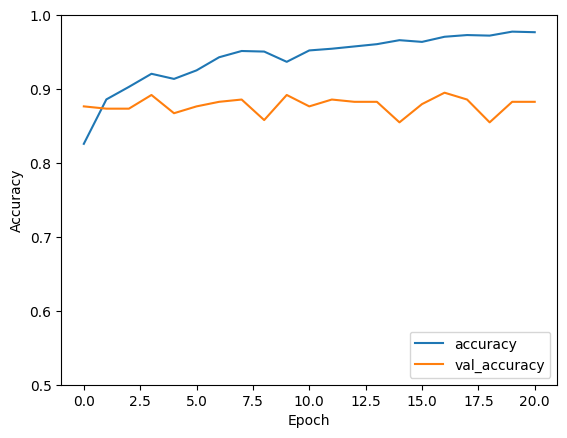

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Save the model

If you like your model, then save your model.

In [14]:
transfer_model.save('../models/transfer_model_gt_2024_04_23.keras')

## Load the model if necessary

If you already saved a model, you can load it again.

In [28]:
# This doesn't seem to work. Found this Github issue, but no real resolution: https://github.com/tensorflow/tensorflow/issues/63853
# transfer_model_loaded = tf.keras.models.load_model('../models/transfer_model_gt_2024_04_23.keras')

# Instead, we can save the weights, but then need to rebuild the model in the exact same way.
transfer_model.save_weights('../models/weights_transfer_model_gt_2024_04_23.weights.h5')

# Later, you can rebuild the model (must be the same structure) and load the weights without needing to retrain (fit) the model
# transfer_model.load_weights('../models/weights_transfer_model_gt_2024_04_23.weights.h5')

## Assess the model

Let's test the model on some new data. 

The `test` folder contains several subdirectories:
* `all` - All Niblet and not-Niblet images
* `test_niblet_alone` - Images of Niblet alone against a white backdrop
* `test_niblet_noshirt` - Images of Niblet alone against a white backdrop without Niblet's maroon shirt
* `test_niblet_others` - Images of Niblet with other stuffed toys against a white backdrop
* `test_niblet_natural` - Images of Niblet in natrual photos
* `test_not_niblet_alone` - Images of not-Niblet stuffed toys alone against a white backdrop
* `test_not_niblet_shirt` - Images of not-Niblet stuffed toys alone against a white backdrop wearing Niblet's maroon shirt
* `test_not_niblet_others` - Images of not-Niblet with other stuffed toys against a white backdrop
* `test_not_niblet_natural` - Images of not-Niblet in natural photos

I encourage you to make up your own test based on these folders.

### Test 1 - Images of Niblet alone against a white backdrop

In [19]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/test_niblet_alone/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=False,
    seed=SEED)

test_iterator = iter(test_set)
test_batch = next(test_iterator)

Found 25 files belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


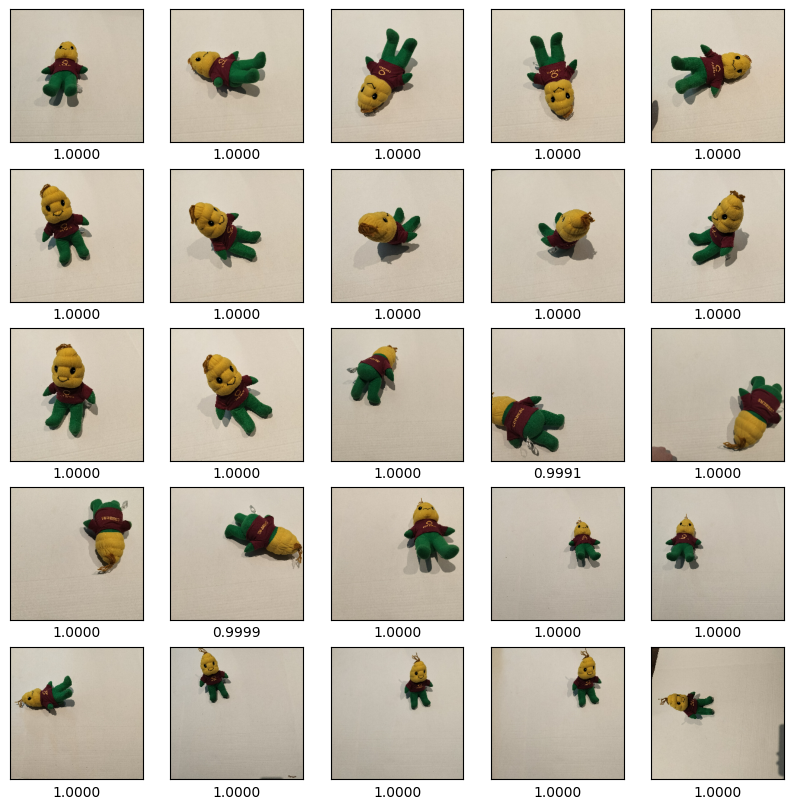

In [20]:
predictions = transfer_model.predict(test_set)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[0][i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

In [31]:
transfer_model.evaluate(test_set, return_dict = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - auc: 0.0000e+00 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - loss: 4.0912e-04 - true_negatives: 0.0000e+00 - true_positives: 25.0000


{'accuracy': 1.0,
 'auc': 0.0,
 'false_negatives': 0.0,
 'false_positives': 0.0,
 'loss': 0.0004091203445568681,
 'true_negatives': 0.0,
 'true_positives': 25.0}

### Test 2 - Images of not-Niblet stuffed toys alone against a white backdrop

In [21]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/test_not_niblet_alone/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=False,
    seed=SEED)

test_iterator = iter(test_set)
test_batch = next(test_iterator)

Found 50 files belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


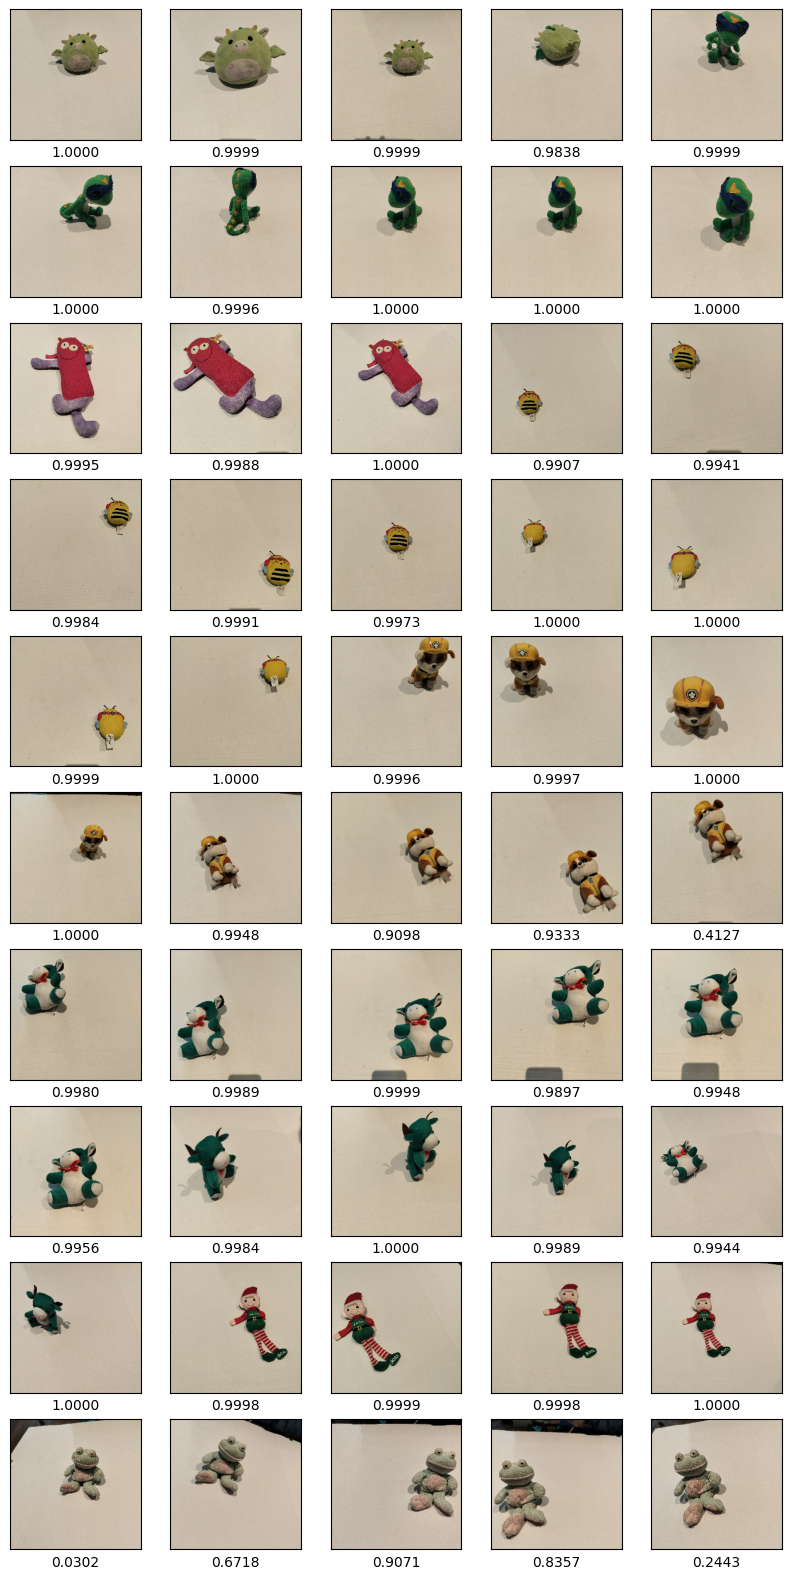

In [22]:
predictions = transfer_model.predict(test_set)

plt.figure(figsize=(10,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[0][i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

In [34]:
transfer_model.evaluate(test_set, return_dict = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1200 - auc: 0.0000e+00 - false_negatives: 0.0000e+00 - false_positives: 44.0000 - loss: 5.8384 - true_negatives: 6.0000 - true_positives: 0.0000e+00


{'accuracy': 0.11999999731779099,
 'auc': 0.0,
 'false_negatives': 0.0,
 'false_positives': 44.0,
 'loss': 5.838389873504639,
 'true_negatives': 6.0,
 'true_positives': 0.0}

### Test 3 - All images

In [23]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/all/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED)

test_iterator = iter(test_set)
test_batch = next(test_iterator)

Found 192 files belonging to 2 classes.


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


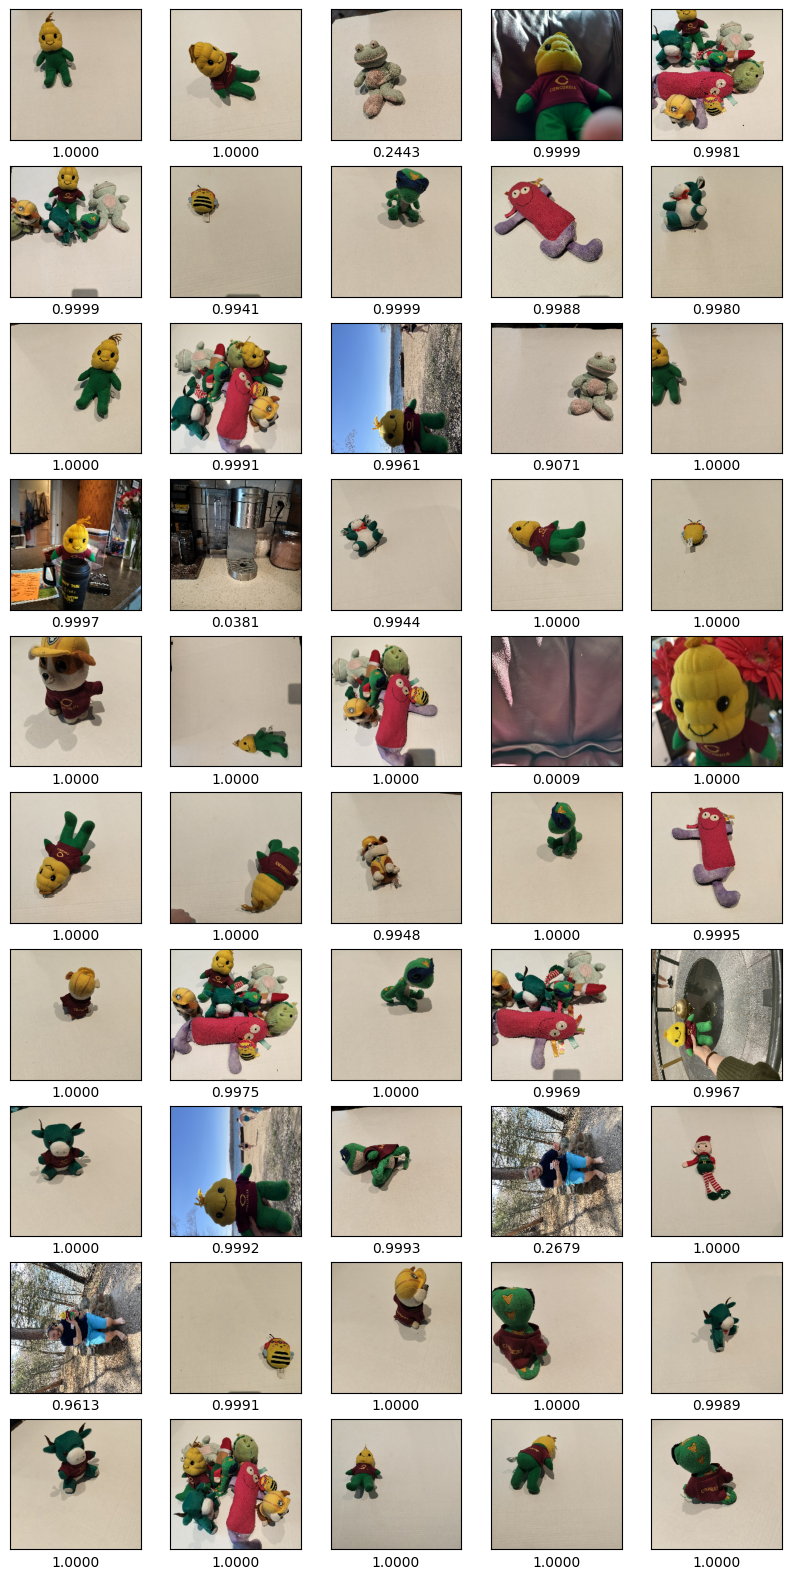

In [24]:
predictions = transfer_model.predict(test_batch)

plt.figure(figsize=(10,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[0][i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

In [25]:
transfer_model.evaluate(test_set, return_dict = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.5677 - auc: 0.6590 - false_negatives: 0.0000e+00 - false_positives: 83.0000 - loss: 3.6332 - true_negatives: 19.0000 - true_positives: 90.0000


{'accuracy': 0.5677083134651184,
 'auc': 0.6590414047241211,
 'false_negatives': 0.0,
 'false_positives': 83.0,
 'loss': 3.633190870285034,
 'true_negatives': 19.0,
 'true_positives': 90.0}